In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
df = pd.read_csv('labeled.csv', sep=',')

In [3]:
df.head(15)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


In [4]:
df['toxic'] = df['toxic'].apply(int)

In [5]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [6]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [7]:
for i in df[df['toxic'] == 1]['comment'].head(5):
    print(i)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [8]:
for i in df[df['toxic'] == 0]['comment'].head(5):
    print(i)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [9]:
train_df, test_df = train_test_split(df, test_size=500)

In [10]:
test_df['toxic'].value_counts()

0    341
1    159
Name: toxic, dtype: int64

In [11]:
train_df['toxic'].value_counts()

0    9245
1    4667
Name: toxic, dtype: int64

In [12]:
snowball = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [13]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [14]:
features = vectorizer.fit_transform(train_df['comment'])

In [15]:
model = LogisticRegression(random_state=42)
model.fit(features, train_df["toxic"])

LogisticRegression(random_state=42)

In [16]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(random_state=0))
]
)

In [17]:
model_pipeline.fit(train_df['comment'], train_df['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001D972677940>)),
                ('model', LogisticRegression(random_state=0))])

In [16]:
model_pipeline.predict(['я люблю булки'])

array([0.])

In [18]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.9259259259259259

In [19]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.6289308176100629

In [20]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])

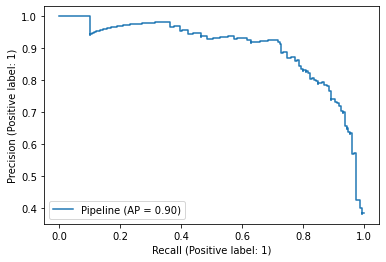

In [21]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])

In [22]:
np.where(prec > 0.95)

(array([344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356,
        357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369,
        370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382,
        383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 398, 399,
        400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412,
        413, 414], dtype=int64),)

In [23]:
thresholds[374]

0.7538628301690228

In [24]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[374])

0.9743589743589743

In [25]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[374])

0.2389937106918239

In [26]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        )
    )
])

In [27]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END ..........................................C=0.1; total time=   0.4s
[CV 2/3] END ..........................................C=0.1; total time=   0.3s
[CV 3/3] END ..........................................C=0.1; total time=   0.4s
[CV 1/3] END ............................................C=1; total time=   0.6s
[CV 2/3] END ............................................C=1; total time=   0.7s
[CV 3/3] END ............................................C=1; total time=   0.5s


C:\Users\Alex\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END .........................................C=10.0; total time=   1.1s


C:\Users\Alex\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END .........................................C=10.0; total time=   1.2s
[CV 3/3] END .........................................C=10.0; total time=   1.3s


C:\Users\Alex\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001D9740C4160>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [28]:
model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.))
]
)

In [29]:
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

C:\Users\Alex\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001D9740C45E0>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [30]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1])

In [31]:
np.where(prec_c_10 > 0.95)

(array([312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
        325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337,
        338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350,
        351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363,
        364, 365, 366, 367], dtype=int64),)

In [32]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[316])

0.98

In [33]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[316])

0.3081761006289308